In [114]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [115]:
data_dir = os.path.dirname(os.getcwd())+'/images'
data_dir

'/home/javier.luna/Desktop/proyecto_pandas/images'

In [116]:
data_dir = pathlib.Path(data_dir)

In [117]:
pandas = list(data_dir.glob('panda/*'))

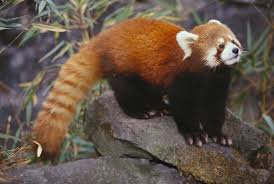

In [118]:
#PIL.Image.open(str(pandas[0]))

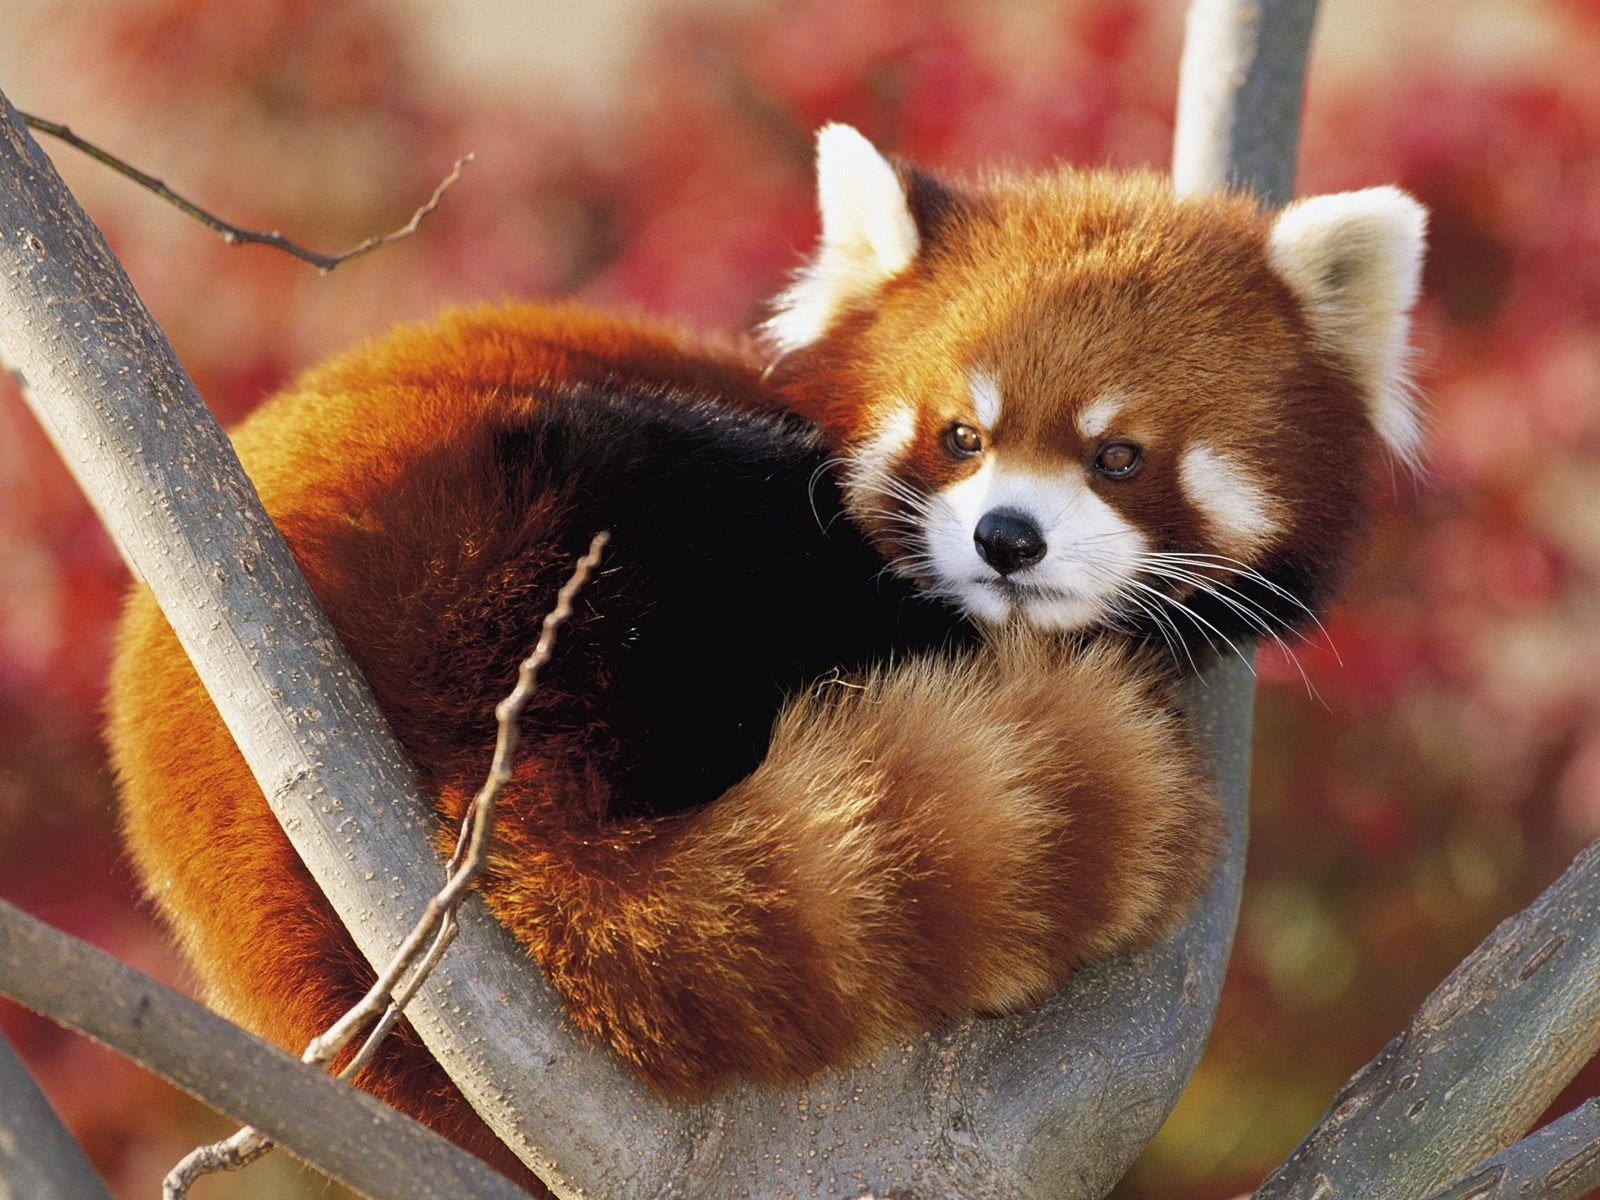

In [119]:
#PIL.Image.open(str(pandas[1]))

# Create a dataset

In [120]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [121]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 187 files belonging to 2 classes.
Using 150 files for training.


In [122]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 187 files belonging to 2 classes.
Using 37 files for validation.


In [123]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [124]:
class_names = train_dataset.class_names
class_names

['not_panda', 'panda']

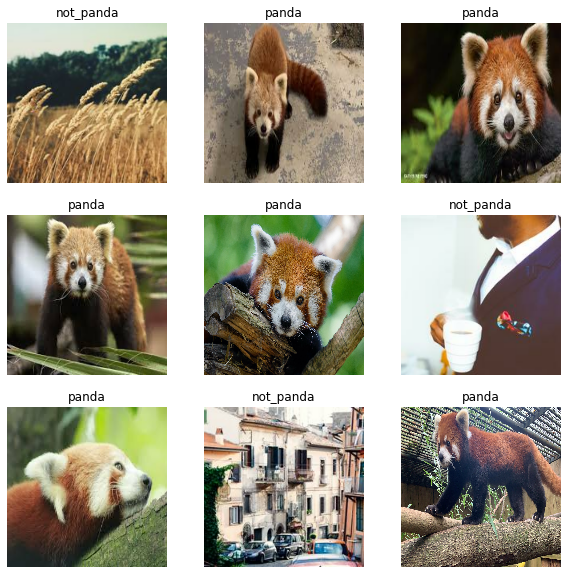

In [125]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure dataset for performance

In [126]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [127]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(
    height_factor=0.2,
    width_factor=0.1)
])

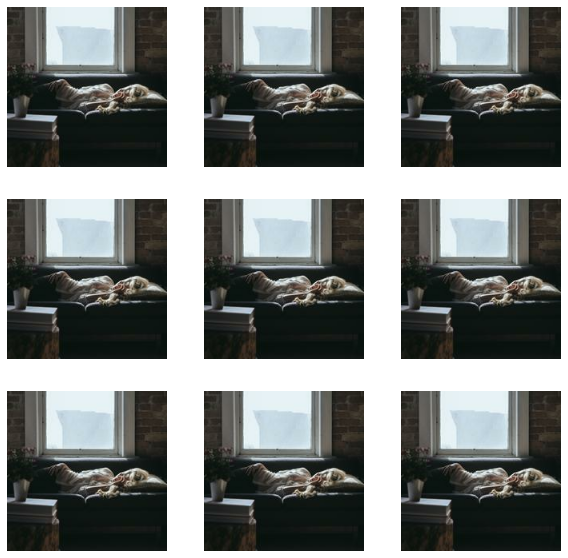

In [128]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [129]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


## Create the base model from the pre-trained model MobileNet V2


In [130]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## Feature extraction

In [131]:
base_model.trainable = False


In [132]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


In [133]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [134]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [135]:
initial_epochs = 5
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=[callback])

Epoch 1/5
5/5 [==============================] - 3s 278ms/step - loss: 0.6903 - accuracy: 0.5333 - val_loss: 0.7064 - val_accuracy: 0.4865
Epoch 2/5
5/5 [==============================] - 1s 198ms/step - loss: 0.6755 - accuracy: 0.5667 - val_loss: 0.6779 - val_accuracy: 0.5135
Epoch 3/5
5/5 [==============================] - 1s 183ms/step - loss: 0.5914 - accuracy: 0.5933 - val_loss: 0.6518 - val_accuracy: 0.5676
Epoch 4/5
5/5 [==============================] - 1s 187ms/step - loss: 0.6429 - accuracy: 0.5800 - val_loss: 0.6262 - val_accuracy: 0.5676
Epoch 5/5
5/5 [==============================] - 1s 184ms/step - loss: 0.6059 - accuracy: 0.6000 - val_loss: 0.6022 - val_accuracy: 0.6486


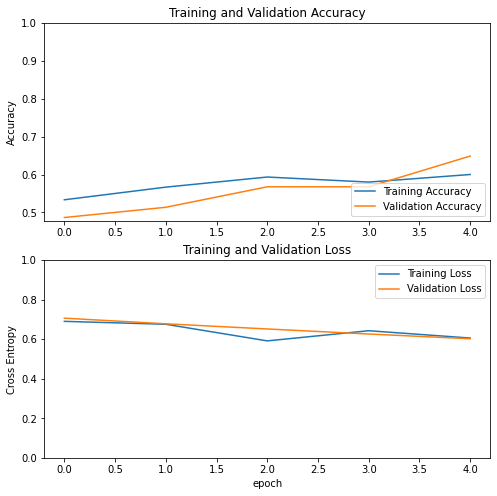

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [137]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [138]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [139]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[callback])

Epoch 5/10
5/5 [==============================] - 4s 336ms/step - loss: 0.3637 - accuracy: 0.8333 - val_loss: 0.2471 - val_accuracy: 0.9730
Epoch 6/10
5/5 [==============================] - 2s 289ms/step - loss: 0.1770 - accuracy: 0.9600 - val_loss: 0.1668 - val_accuracy: 0.9730
Epoch 7/10
5/5 [==============================] - 2s 277ms/step - loss: 0.1244 - accuracy: 0.9533 - val_loss: 0.1402 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 2s 291ms/step - loss: 0.0985 - accuracy: 0.9600 - val_loss: 0.1375 - val_accuracy: 0.9730
Epoch 9/10
5/5 [==============================] - 2s 326ms/step - loss: 0.0989 - accuracy: 0.9667 - val_loss: 0.1245 - val_accuracy: 0.9730
Epoch 10/10
5/5 [==============================] - 2s 333ms/step - loss: 0.0716 - accuracy: 0.9667 - val_loss: 0.1341 - val_accuracy: 0.9459


In [140]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

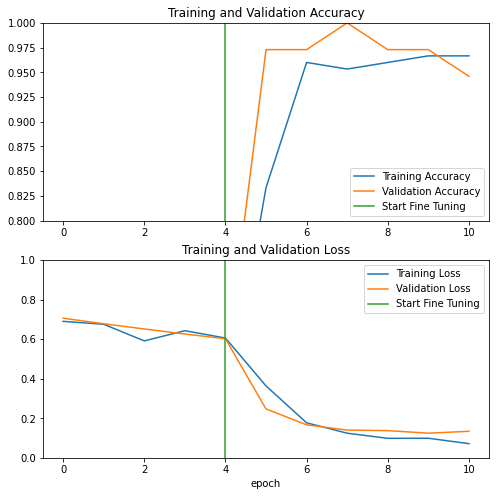

In [141]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [143]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

OverflowError: cannot convert float infinity to integer

Predictions:
 [1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1]
Labels:
 [1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1]


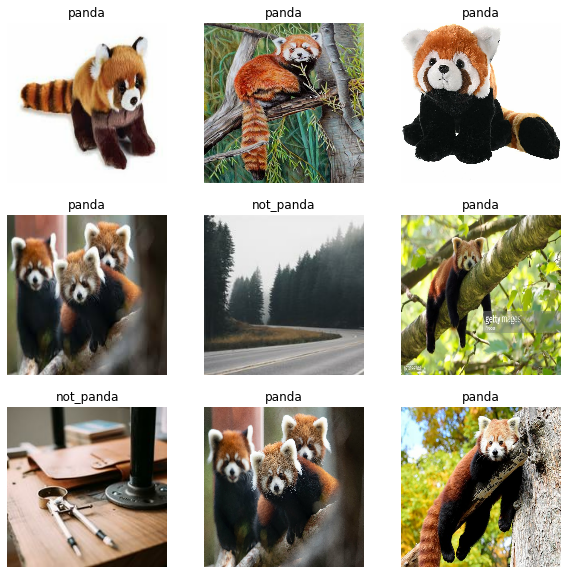

In [145]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Predict on single image

In [146]:
import cv2

ModuleNotFoundError: No module named 'cv2'